# Score de CVs/Resumes Versión 2.

-En esta versión utilizaremos keywoards obtenidas del notebook 'Job_Positions_Extract&Analysis' envés de keywords obtenidas desde nuestro modelo. Y machearemos directamente estas palabras con nuestros CVs.
Luego, como en la version_1, le asignaremos un score para cada keyword y los plotearemos para cada candidato.

**Workflow (Continuación)**:

10. Extraemos los CVs/Resumes usando PyPDF y los convertimos en string.
11. Contruimos el perfil del candidato (candidate profile) mediante el macheo de las keywords obtenidas del paso 9- al texto contenido en el CV.
12. Contamos las palabras para cada categoria e imprimimos nuestro 'candidate profile'.
13. Visualizamos el candidate profile con matplotlib.

In [9]:
#Importamos las librerias necesarias

import PyPDF2
import os
import collections
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import spacy
from spacy.matcher import PhraseMatcher

#Para etapa 10:
import matplotlib.pyplot as plt
%matplotlib inline

### 10-Extraemos los CVs/Resumes usando PyPDF y los convertimos en string.

In [10]:
#Leemos los CVs almacenados en nuestra carpeta y los extraemos uno por uno mediante la libreria PyPDF; devolviendonos
#una secuencia de strings. Estos strings son preprocesados y luego van a ser procesados nuevamente para crear el perfil
#del candidato. 
pathCVs='Resumes'
onlyfiles = [os.path.join(pathCVs, f) for f in os.listdir(pathCVs) if os.path.isfile(os.path.join(pathCVs, f))]

In [11]:
#Funcion para extraer las palabras del CV:
import collections
def pdfextract(file):
    pdf_file = open(file, 'rb')
    read_pdf = PyPDF2.PdfFileReader(pdf_file)
    number_of_pages = read_pdf.getNumPages()
    c = collections.Counter(range(number_of_pages))
    for i in c:
        page = read_pdf.getPage(i)
        page_content = page.extractText()
    return (page_content.encode('utf-8'))

In [12]:
#Colocamos las keywords (TOP 5 Tools y TOP 5 Skills) obtenidas en 'Job_Positions_Extract&Analysis' para cada área a mano:
keywords_DS=['python','r','sql','spark','cloud','stadistics', 'machine learning', 'visualization', 'prediction', 'research']
keywords_ML=['python','tensorflow','cloud','java','c++','machine learning', 'research', 'deep learning', 'statistics', 'natural language processing']
keywords_DE=['cloud','sql','python','spark','amazon web services','aws','etl', 'optimization', 'machine learning', 'visualization', 'statistics']
keywords_JP=['java','git','oracle','cloud','jquery','supervised', 'clustering', 'power bi', 'bayes']
keywords_HC=['python','r','sql','spark','cloud','stadistics', 'machine learning', 'visualization', 'prediction', 'research']

#MEJORA: importar y cargar directamente estas keywords sin tener que ponerlas a mano.

### 11-Contruimos el perfil del candidato (candidate profile) mediante el macheo de las keywords obtenidas del paso 9- al texto contenido en el CV:

In [13]:
#El 'PhraseMatcher" de Spacy es usado para machear el array (obtenido de word2vec) con el texto extraido. 
#De esta manera asignará cada skill a una keyword particular con un SCORE acorde. 

nlp = spacy.load('en_core_web_sm')

def create_profile(file):
    text = str(pdfextract(file))
    text = text.replace("\\n", "")
    text = text.lower()
   
    #ATENCION: las palabras de los vectores deben estar en MINUSCULAS (ya que arriba ponemos text.lower... entonces
    #NO hacer 'Python' ni 'SQL'... sino 'python' y 'sql')
    DS = [nlp(text) for text in keywords_DS]
    ML = [nlp(text) for text in keywords_ML]
    DE = [nlp(text) for text in keywords_DE]
    JP = [nlp(text) for text in keywords_JP]
    HCM = [nlp(text) for text in keywords_HC]
    #Consultant = [nlp(text) for text in ['extractions','soap']]


    print("*******************************************")
    #print(stats_words,NLP_words)
    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('DataS', None, *DS)
    matcher.add('ML', None, *ML)
    matcher.add('DataE', None, *DE)
    matcher.add('JavaP', None, *JP)
    matcher.add('HCM', None, *HCM)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  #Obtenemos el ID único.
        span = doc[start : end]                #obtenemos la porción que coincide/machea en el documento. 
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    print("KEYWORDS")
    print(keywords)
    
    ## Convertimos el string de KeyWords a DataFrame:
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    print("********************DF********************")
    print(df)
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
    
    name = filename.split('_')
    print(name)
    name2 = name[0]
    name2 = name2.lower()
    ## Convertimos string a DataFrame:
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)
    print("******************DATAF**************")
    print(dataf)

    return(dataf)

In [14]:
#Ejecutamos la función create_profile de arriba pasandole cada CV:
final_db=pd.DataFrame()
i=0
while i < len(onlyfiles):
    file=onlyfiles[i]
    dat=create_profile(file)

    final_db=final_db.append(dat)
    i+=1
    #print(final_db)

*******************************************
KEYWORDS
ML statistics (1)
DataE statistics (1)
HCM python (1)
DataS python (1)
ML python (1)
DataE python (1)
ML c++ (1)
HCM r (1)
DataS r (1)
HCM sql (1)
DataS sql (1)
DataE sql (1)
HCM research (1)
DataS research (1)
ML research (1)
JavaP clustering (1)
********************DF********************
           Keywords_List
0      ML statistics (1)
1   DataE statistics (1)
2         HCM python (1)
3       DataS python (1)
4          ML python (1)
5       DataE python (1)
6             ML c++ (1)
7              HCM r (1)
8            DataS r (1)
9            HCM sql (1)
10         DataS sql (1)
11         DataE sql (1)
12      HCM research (1)
13    DataS research (1)
14       ML research (1)
15  JavaP clustering (1)
['AmanSharma']
******************DATAF**************
   Candidate Name Subject      Keyword Count
0      amansharma      ML  statistics      1
1      amansharma   DataE  statistics      1
2      amansharma     HCM      python      

### 12-Contamos las palabras para cada categoria e imprimimos nuestro 'candidate profile'.

In [15]:
final_db2 = final_db['Keyword'].groupby([final_db['Candidate Name'], final_db['Subject']]).count().unstack()
final_db2.reset_index(inplace = True)
final_db2.fillna(0,inplace=True)
candidate_data = final_db2.iloc[:,1:]
candidate_data.index = final_db2['Candidate Name']

#Pasamos a csv el 'candidate profile' para imprimirlo con Pandas:
cand=candidate_data.to_csv('candidate_profile.csv')
cand_profile=pd.read_csv('candidate_profile.csv')
cand_profile

,Candidate Name,DataE,DataS,HCM,JavaP,ML
0,amansharma,3.0,4.0,4.0,1.0,4.0
1,calongefederico,1.0,1.0,1.0,1.0,1.0
2,chandler,0.0,1.0,1.0,0.0,0.0
3,meghnalohani,2.0,2.0,2.0,2.0,4.0
4,phoebe buffay,0.0,1.0,1.0,0.0,2.0
5,vaishali bijoy,0.0,1.0,1.0,0.0,0.0


### 13-Visualizamos el candidate profile con matplotlib.

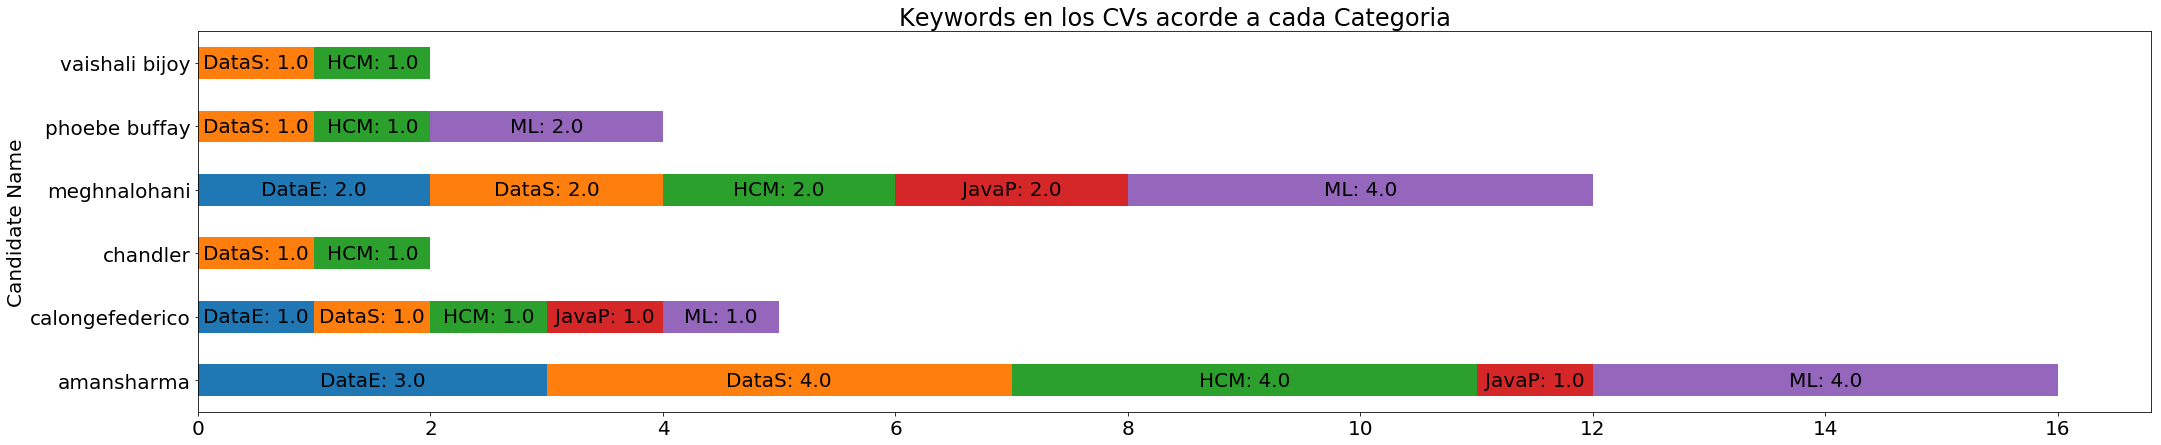

In [16]:
#Visualizamos el 'candidate profile' mediante un gráfico de barras usando los scores para cada skill.
#De esta manera el reclutador interpretará facilmente cada perfil de candidato. 

plt.rcParams.update({'font.size': 20})
ax = candidate_data.plot.barh(title="Keywords en los CVs acorde a cada Categoria", legend=False, figsize=(35,7), stacked=True)
skills = []
for j in candidate_data.columns:
    for i in candidate_data.index:
        skill = str(j)+": " + str(candidate_data.loc[i][j])
        skills.append(skill)
patches = ax.patches
for skill, rect in zip(skills, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., skill, ha='center', va='center')
plt.show()

In [1]:
#Conclusiones:
#De esta manera podemos machear cada skill en el cv del candidato con una keyword particular (machine learning, programming, etc.)
#basandonos en la distancia semantica entre las palabras (utilizando Word Embeddings). 
#El macheo lo realizamos con 'PhraseMatcher" de Spacy; y creamos un SCORE para cada keyword.
#Los SCORES finales los visualizamos en un bar plot.

#Mejoras:
#Tener un mejor CORPUS y mucho más grande que el skills.txt que tenemos (con vocabulario limitado) para que el modelo sea más preciso. 
#Agregar las palabras más comunes.

# Referencias

1. https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
2. https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/
3. https://app.sketchengine.eu/
